In [ ]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from math import floor
from termcolor import colored as cl

plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

In [ ]:
xrp_1d = yf.download(tickers='XRP-USD', start='2019-09-01', end = '2021-08-11', interval='1h')
xrp_1d.drop(columns = ['Adj Close'], inplace = True)
xrp_1d.reset_index(inplace = True)
xrp_1d.rename(columns = {'index' : "Datetime"}, inplace = True)
xrp_1d.set_index(pd.to_datetime(xrp_1d['Datetime'], infer_datetime_format=True), inplace=True)
xrp_1d.drop(columns = 'Datetime', inplace = True)
xrp_1d

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Datetime,,,,,
2019-09-01 01:00:00+01:00,0.258500,0.259200,0.258200,0.259100,0
2019-09-01 02:00:00+01:00,0.259200,0.259400,0.258100,0.258400,328452
2019-09-01 03:00:00+01:00,0.258300,0.258500,0.257400,0.257800,269123
2019-09-01 04:00:00+01:00,0.257800,0.258700,0.257800,0.258500,180066
2019-09-01 05:00:00+01:00,0.258500,0.259000,0.258100,0.258100,212062
...,...,...,...,...,...
2021-08-10 20:00:00+01:00,0.827692,0.835830,0.827692,0.834750,0
2021-08-10 21:00:00+01:00,0.837847,0.845152,0.834169,0.843693,4478464
2021-08-10 22:00:00+01:00,0.843860,0.858775,0.843860,0.858775,66098944


In [ ]:
def sma(price, period):
    sma = price.rolling(period).mean()
    return sma

def ao(price, period1, period2):
    median = price.rolling(2).median()
    short = sma(median, period1)
    long = sma(median, period2)
    ao = short - long
    ao_df = pd.DataFrame(ao).rename(columns = {'Close':'ao'})
    return ao_df

xrp_1d['ao'] = ao(xrp_1d['Close'], 5, 34)
xrp_1d = xrp_1d.dropna()
xrp_1d.tail()

,Open,High,Low,Close,Volume,ao
Datetime,,,,,,
2021-08-10 20:00:00+01:00,0.827692,0.835830,0.827692,0.834750,0,0.005187
2021-08-10 21:00:00+01:00,0.837847,0.845152,0.834169,0.843693,4478464,0.007011
2021-08-10 22:00:00+01:00,0.843860,0.858775,0.843860,0.858775,66098944,0.012528
2021-08-10 23:00:00+01:00,0.861440,0.861440,0.852071,0.852293,92512512,0.019151
2021-08-11 00:00:00+01:00,0.849918,0.854050,0.847675,0.851247,23741440,0.023781


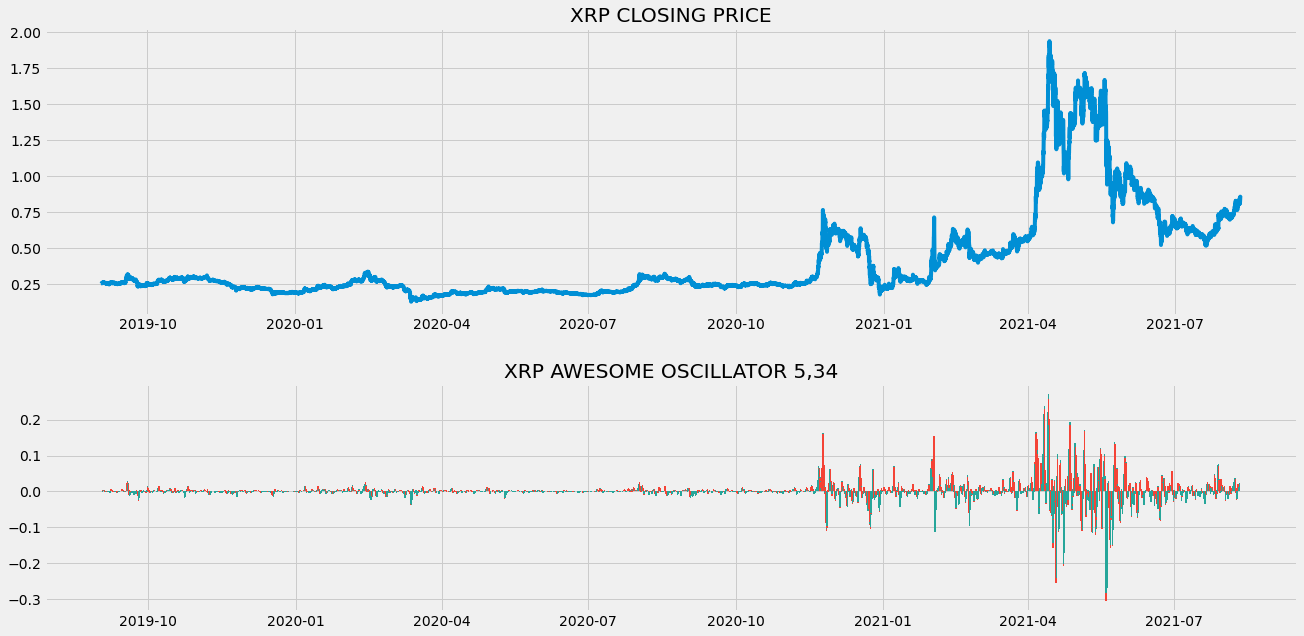

In [ ]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((10,1), (6,0), rowspan = 4, colspan = 1)
ax1.plot(xrp_1d['Close'])
ax1.set_title('XRP CLOSING PRICE')
for i in range(len(xrp_1d)):
    if xrp_1d['ao'][i-1] > xrp_1d['ao'][i]:
        ax2.bar(xrp_1d.index[i], xrp_1d['ao'][i], color = '#f44336')
    else:
        ax2.bar(xrp_1d.index[i], xrp_1d['ao'][i], color = '#26a69a')
ax2.set_title('XRP AWESOME OSCILLATOR 5,34')
plt.show()

In [ ]:
def implement_ao_crossover(price, ao):
    buy_price = []
    sell_price = []
    ao_signal = []
    signal = 0
    
    for i in range(len(ao)):
        if ao[i] > 0 and ao[i-1] < 0:
            if signal != 1:
                buy_price.append(price[i])
                sell_price.append(np.nan)
                signal = 1
                ao_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                ao_signal.append(0)
        elif ao[i] < 0 and ao[i-1] > 0:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(price[i])
                signal = -1
                ao_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                ao_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            ao_signal.append(0)
    return buy_price, sell_price, ao_signal

buy_price, sell_price, ao_signal = implement_ao_crossover(xrp_1d['Close'], xrp_1d['ao'])

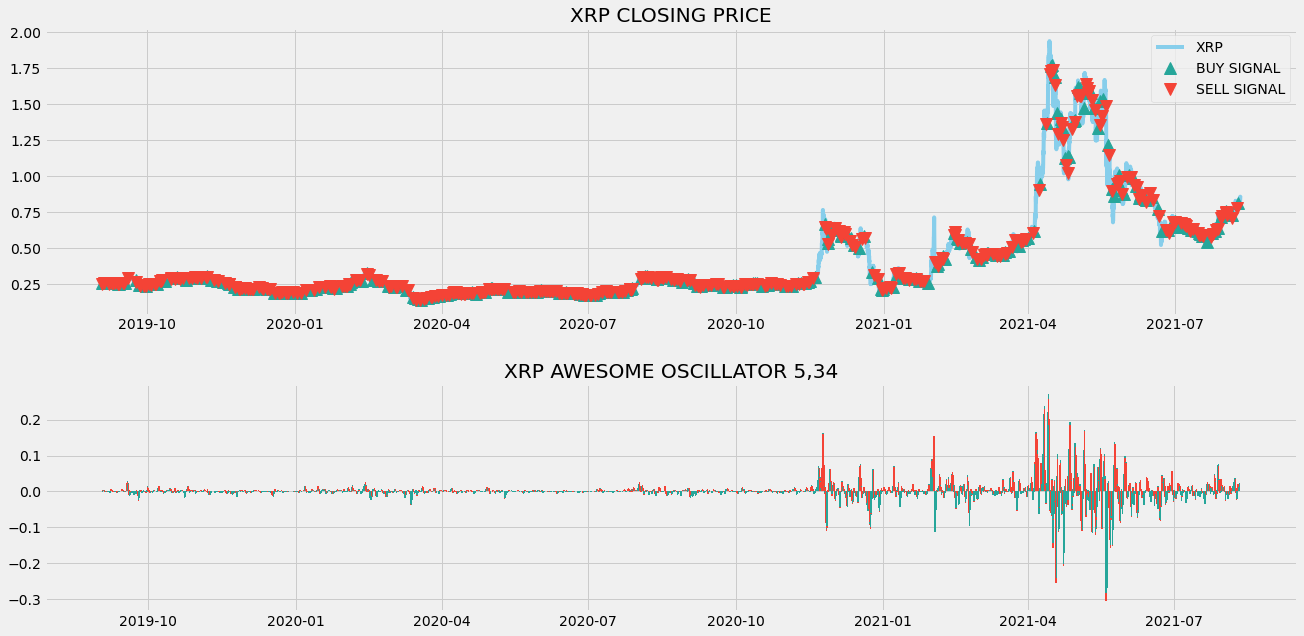

In [ ]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((10,1), (6,0), rowspan = 4, colspan = 1)
ax1.plot(xrp_1d['Close'], label = 'XRP', color = 'skyblue')
ax1.plot(xrp_1d.index, buy_price, marker = '^', markersize = 12, color = '#26a69a', linewidth = 0, label = 'BUY SIGNAL')
ax1.plot(xrp_1d.index, sell_price, marker = 'v', markersize = 12, color = '#f44336', linewidth = 0, label = 'SELL SIGNAL')
ax1.legend()
ax1.set_title('XRP CLOSING PRICE')
for i in range(len(xrp_1d)):
    if xrp_1d['ao'][i-1] > xrp_1d['ao'][i]:
        ax2.bar(xrp_1d.index[i], xrp_1d['ao'][i], color = '#f44336')
    else:
        ax2.bar(xrp_1d.index[i], xrp_1d['ao'][i], color = '#26a69a')
ax2.set_title('XRP AWESOME OSCILLATOR 5,34')
plt.show()

In [ ]:
position = []
for i in range(len(ao_signal)):
    if ao_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(xrp_1d['Close'])):
    if ao_signal[i] == 1:
        position[i] = 1
    elif ao_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
ao = xrp_1d['ao']
close_price = xrp_1d['Close']
ao_signal = pd.DataFrame(ao_signal).rename(columns = {0:'ao_signal'}).set_index(xrp_1d.index)
position = pd.DataFrame(position).rename(columns = {0:'ao_position'}).set_index(xrp_1d.index)

frames = [close_price, ao, ao_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,Close,ao,ao_signal,ao_position
Datetime,,,,
2019-09-02 11:00:00+01:00,0.254600,-0.001421,-1,0
2019-09-02 12:00:00+01:00,0.255700,-0.001316,0,0
2019-09-02 13:00:00+01:00,0.255000,-0.001095,0,0
2019-09-02 14:00:00+01:00,0.258000,-0.000616,0,0
2019-09-02 15:00:00+01:00,0.257600,0.000019,1,1
...,...,...,...,...
2021-08-10 20:00:00+01:00,0.834750,0.005187,0,1
2021-08-10 21:00:00+01:00,0.843693,0.007011,0,1
2021-08-10 22:00:00+01:00,0.858775,0.012528,0,1


In [ ]:
xrp_ret = pd.DataFrame(np.diff(xrp_1d['Close'])).rename(columns = {0:'returns'})
ao_strategy_ret = []

for i in range(len(xrp_ret)):
    returns = xrp_ret['returns'][i]*strategy['ao_position'][i]
    ao_strategy_ret.append(returns)
    
ao_strategy_ret_df = pd.DataFrame(ao_strategy_ret).rename(columns = {0:'ao_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/xrp_1d['Close'][-1])
ao_investment_ret = []

for i in range(len(ao_strategy_ret_df['ao_returns'])):
    returns = number_of_stocks*ao_strategy_ret_df['ao_returns'][i]
    ao_investment_ret.append(returns)

ao_investment_ret_df = pd.DataFrame(ao_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(ao_investment_ret_df['investment_returns']), 2)
profit_percentage = round((total_investment_ret/investment_value)*100, 2)
print(cl('Profit gained from the AO strategy by investing $100k in XRP : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the AO strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the AO strategy by investing $100k in XRP : 172324.28
Profit percentage of the AO strategy : 172.32%


In [ ]:
strategy.to_csv('XRP_AO_1hr_TRADE_STRATEGY')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d12c285c-6789-4c45-9ad7-1be9b4d60622' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>